# Image Classification

## Conducting an exploratory data analysis

In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
# Downloading the dataset from Kaggle using the opendatasets library installed above
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/jehanbhathena/weather-dataset")

Skipping, found downloaded files in "./weather-dataset" (use force=True to force download)


In [ ]:
# Inporting necessary libraries
import os
import keras
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator as IDG
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3, Xception, ResNet152V2, ResNet50V2, ResNet50
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Layer, ReLU, Add, InputLayer, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [ ]:
# Count and show the number of classes for images
root_path = '/content/weather-dataset/dataset'

class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

print(f"Total No. of Classes : {n_classes}")

Total No. of Classes : 11


In [ ]:
class_names

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

In [ ]:
# Count and show the images' distribution among classes
class_dis = [len(os.listdir(root_path + "/" + name)) for name in class_names]
class_dis

[698, 851, 475, 639, 591, 377, 526, 232, 1160, 692, 621]

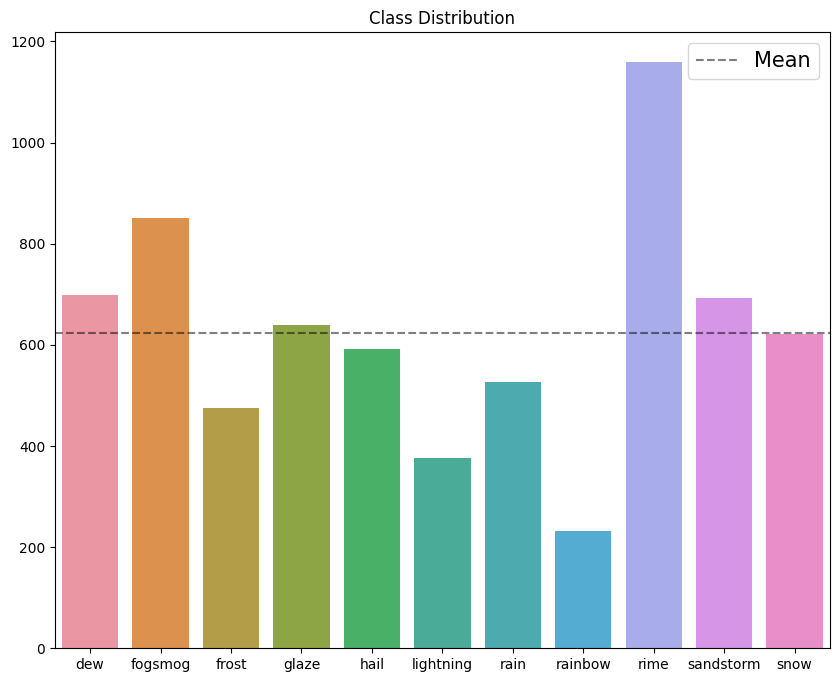

In [ ]:
# Plotting the images' distribution among classes
plt.figure(figsize=(10,8))
sns.barplot(
    x=class_names,
    y=class_dis
)
plt.axhline(np.mean(class_dis), alpha=0.5, linestyle='--', color='k', label="Mean")
plt.title("Class Distribution")
plt.legend(fontsize=15)
plt.show()

The images are not distributed equally among classes, this might affect the model, but for the basic scenario let's work with the data as it is without balancing the classes.

## Developing and evaluating a multi-class classification model to detect the weather condition in the image

In [ ]:
# Initializing DataGenerator with data augmentation settings
train_gen = IDG(rescale=1./255, horizontal_flip=True, rotation_range=20, validation_split=0.2)

# Loading Data using the data generator
train_ds = train_gen.flow_from_directory(root_path, target_size=(256,256), class_mode="binary", subset='training', shuffle=True, batch_size=32)
valid_ds = train_gen.flow_from_directory(root_path, target_size=(256,256), class_mode="binary", subset='validation', shuffle=True, batch_size=32)

Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.


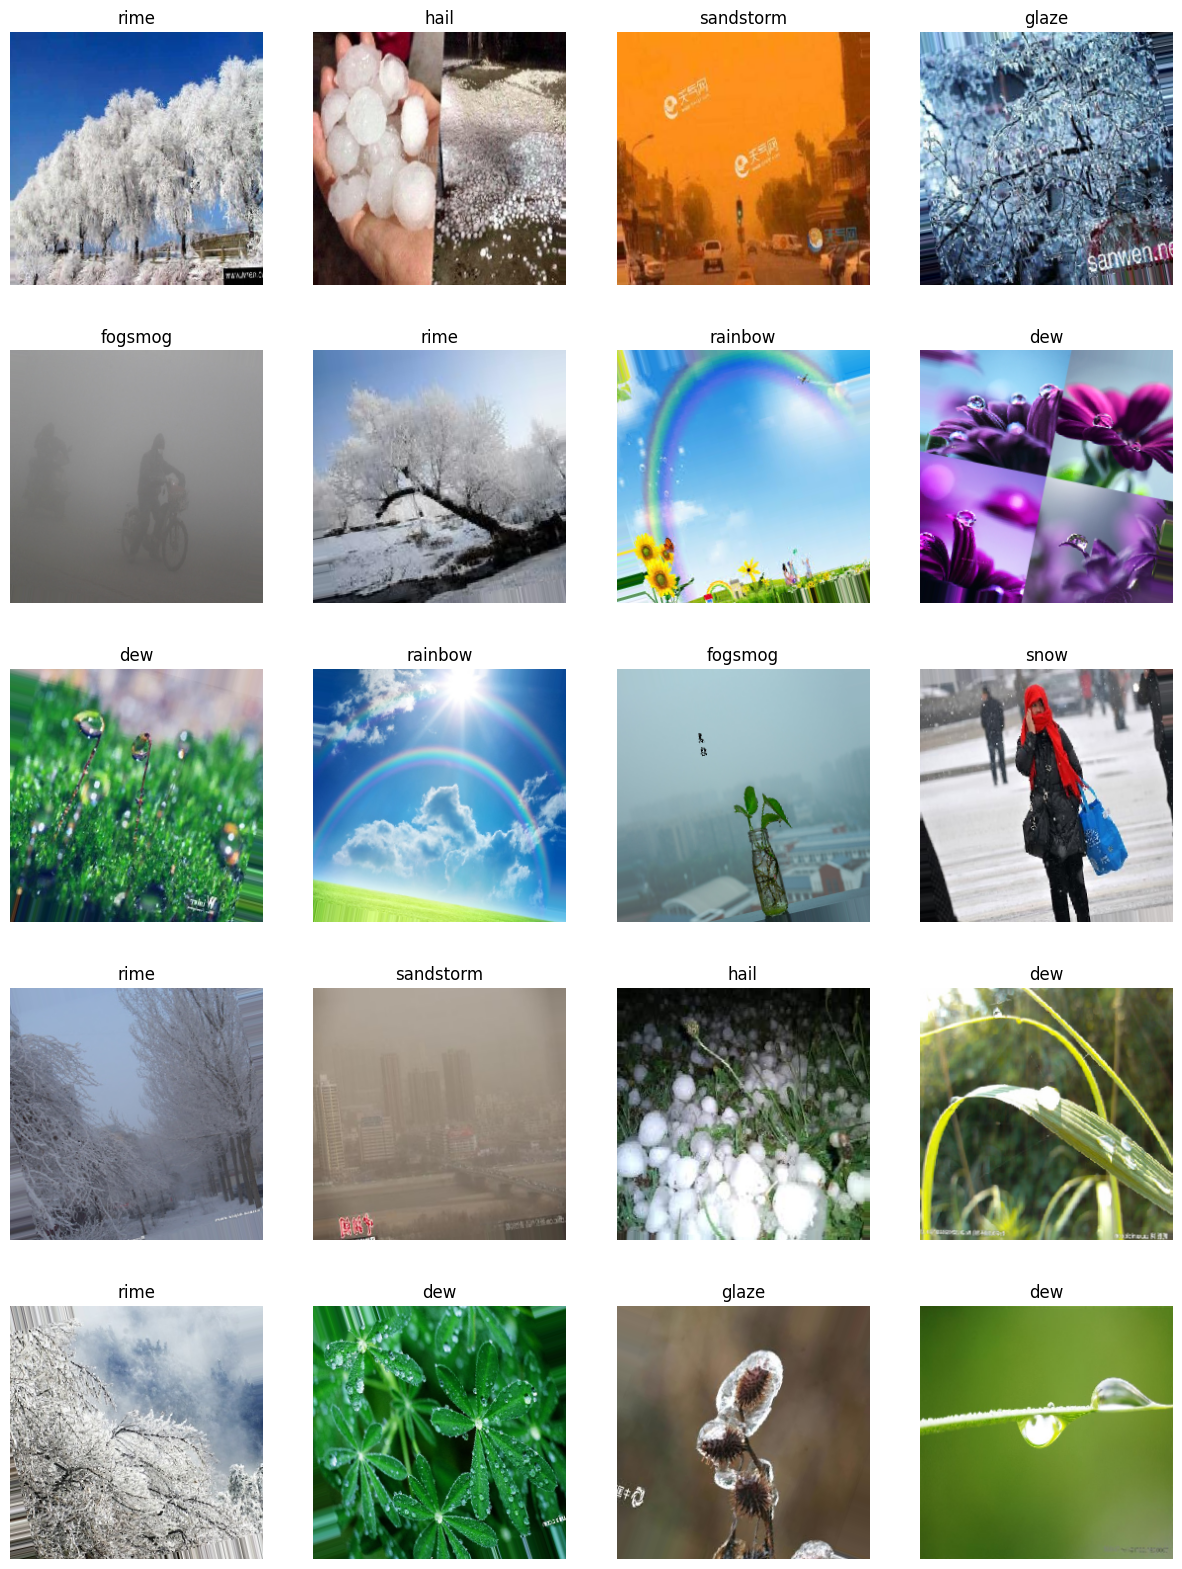

In [ ]:
# Display a grid of image samples from the training dataset
i=1
plt.figure(figsize=(15,20))
for images, labels in train_ds:
    id = np.random.randint(len(images))
    image, label = images[id], int(labels[id])

    plt.subplot(5, 4, i)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis('off')

    i+=1
    if i>=21: break

plt.show()

In [ ]:
# Defining and compiling a convolutional neural network (CNN) model using Keras

name = 'resnet'
base_model = ResNet152V2(include_top=False, input_shape=(256,256,3))
base_model.trainable = False

# Model
model = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation="softmax")
])

# Compiling
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

- Using a pre-trained model like ResNet-152V2 as a base model has several advantages. These models are trained on large datasets and have learned to extract useful features from images. By setting include_top=False, I removed the final classification layers, allowing you to fine-tune the model for my specific task. This saves a lot of time and computational resources compared to training a model from scratch.

- Callbacks are essential for monitoring and controlling the training process. EarlyStopping prevents overfitting by stopping training when validation loss doesn't improve for a specified number of epochs. ModelCheckpoint saves the best model weights, allowing me to restore the model with the best performance.

- The above settings and configurations are chosen to create a robust and well-performing deep learning model for my multi-class classification task, leveraging transfer learning, regularization techniques (dropout), and monitoring during training.

In [ ]:
# Fitting our data to the model
model.fit(train_ds, epochs=10, callbacks=cbs, validation_data=valid_ds)

Epoch 1/10
172/172 [==============================] - ETA: 0s - loss: 0.9429 - accuracy: 0.6947

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


172/172 [==============================] - 161s 815ms/step - loss: 0.9429 - accuracy: 0.6947 - val_loss: 0.4537 - val_accuracy: 0.8356
Epoch 2/10
172/172 [==============================] - 141s 818ms/step - loss: 0.5189 - accuracy: 0.8283 - val_loss: 0.4370 - val_accuracy: 0.8510
Epoch 3/10
172/172 [==============================] - 136s 793ms/step - loss: 0.4324 - accuracy: 0.8545 - val_loss: 0.4422 - val_accuracy: 0.8554
Epoch 4/10
172/172 [==============================] - 133s 771ms/step - loss: 0.3690 - accuracy: 0.8802 - val_loss: 0.4482 - val_accuracy: 0.8546
Epoch 5/10
172/172 [==============================] - 140s 815ms/step - loss: 0.3397 - accuracy: 0.8833 - val_loss: 0.4297 - val_accuracy: 0.8627
Epoch 6/10
172/172 [==============================] - 133s 772ms/step - loss: 0.3067 - accuracy: 0.8962 - val_loss: 0.4315 - val_accuracy: 0.8707
Epoch 7/10
172/172 [==============================] - 134s 781ms/step - loss: 0.3067 - accuracy: 0.8959 - val_loss: 0.4494 - val_accura

In [ ]:
# save model and its architecture
model.save('my_model')

In [ ]:
# Loading the model
model = load_model('my_model')

1/1 [==============================] - 0s 34ms/step


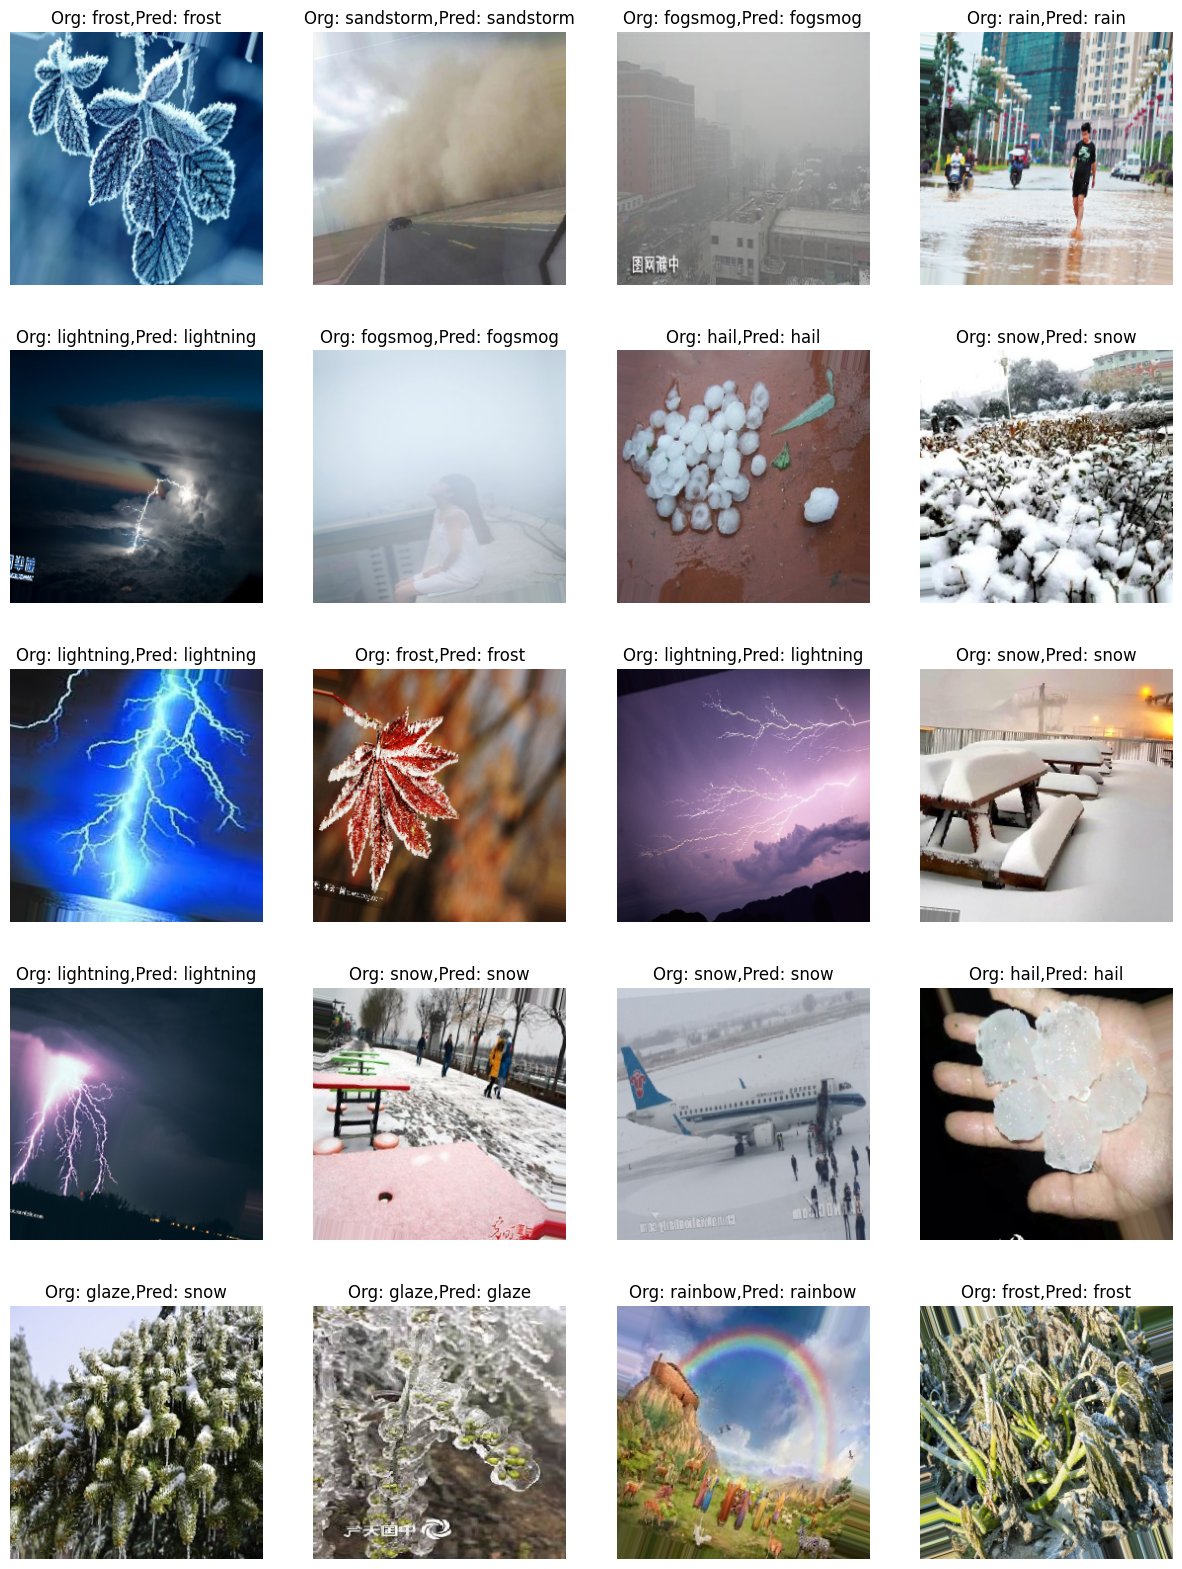

In [ ]:
# Visualizing a set of images along with their original labels and the labels predicted by the loaded deep learning model
i=1
plt.figure(figsize=(15,20))
for images, labels in train_ds:
    id = np.random.randint(len(images))
    image, label = images[id], int(labels[id])
    pred_label = class_names[np.argmax(model.predict(image[np.newaxis,...]))]
    plt.subplot(5, 4, i)
    plt.imshow(image)
    plt.title(f"Org: {class_names[label]},Pred: {pred_label}")
    plt.axis('off')

    i+=1
    if i>=21: break

plt.show()

In [ ]:
# Evaluating the model's performance on validation data
model.evaluate(valid_ds)

43/43 [==============================] - 29s 613ms/step - loss: 0.4228 - accuracy: 0.8685


[0.42278650403022766, 0.8685171604156494]

## Prediction on new images

In [ ]:
# Defining a function to predict an image's weather condition from 11 classes
import numpy as np
from keras.preprocessing import image

def predict_weather_condition(image_path, model, class_names):
    # Loading the image and preprocessing it
    img = image.load_img(image_path, target_size=(256, 256))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Rescaling the image (if not already)

    # Predicting the class using the loaded model
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]

    return predicted_class

In [ ]:
# Example usage
image_path = '/content/imagesa9681a0f-bf5c-479c-bd10-295906fd293d.jpg'
predicted_class = predict_weather_condition(image_path, model, class_names)
print(f'Predicted weather condition: {predicted_class}')

1/1 [==============================] - 0s 39ms/step
Predicted weather condition: snow


In [ ]:
!zip -r /content/model.zip /content/my_model

  adding: content/my_model/ (stored 0%)
  adding: content/my_model/fingerprint.pb (stored 0%)
  adding: content/my_model/keras_metadata.pb (deflated 97%)
  adding: content/my_model/saved_model.pb (deflated 92%)
  adding: content/my_model/variables/ (stored 0%)
  adding: content/my_model/variables/variables.index (deflated 79%)
  adding: content/my_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/my_model/assets/ (stored 0%)


In [ ]:
from google.colab import files
files.download("/content/model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## References

I was highly inspired from the below resource:
- https://www.kaggle.com/code/utkarshsaxenadn/weather-classification-resnet-acc-91#ResNet152V2